# 2D convolution of satellite images - playground
for demonstration purposes

In [1]:
import numpy as np
import pandas as pd
import rasterio 
from src.models.data import *
from src.visualization.visualize_satimg import convert_sat_img, define_band_colors, get_band_properties
from matplotlib import pyplot as plt
import os, sys
%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


## User settings

In [2]:
# source path
img_source_dir = "/media/hh/hd_internal/_data_DS/DSR/satelliteImages/Borneo/3093/"
# source file name
img_source_fn = "20180427_020348_103a_3B_AnalyticMS.tif"
# type of file (ordering of bands)
src_type = "BGRN"
# row and column indexes of excerpt
r1, r2, c1, c2 = 1000, 1700, 4000, 4800

# output format of graphics file (set to None to suppress)
img_out_format = "png"
img_out_format = None

img_out_dir = "/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/not_for_distribution/presentations/images/"
img_out_fn = "exemplary_scene_Borneo_01"

# some input args for convert_sat_img:
# list all types of scaling that are supposed to take place
scaling_type = ["percentile", "equalize_adapthist"]
#scaling_type = ["percentile"]
#scaling_type = ["equalize_adapthist"]

do_scale_bands_separate = True
# percentile; values above it will be clipped if method "percentile" is in scaling_type
percentile=99.8
# clip limit for equalize_adapthist - default 0.03; the higher the value, the brighter the image
clip_limit=0.01

# graphics defaults
figsize = (10,10)
plt.rcParams["figure.figsize"] = figsize

In [3]:
# open dataset
src = rasterio.open(os.path.join(img_source_dir, img_source_fn))
# read all data into numpy array; notes:
# - the bands are in the first dimension
# - we might also read using a window
# - reading the image as a masked array does not make sense because function convert_sat_img
#   uses sklearn for image manipulation, which ignores masked arrays, hence we need the
#   an explicit mask array
img_full = src.read(masked=False)
mask_full = src.read_masks()

In [4]:
# cut down to desired excerpt
img_arr = img_full[:, r1:r2, c1:c2]
if mask_full is not None:
    mask_arr = mask_full[:, r1:r2, c1:c2]
else:
    mask_arr = None

In [5]:
# call conversion function
img_rgb, _, _ = convert_sat_img(img_arr, src,
                                src_type=src_type,
                                mask_arr=mask_arr,
                                pca=False,
                                scaling_type=scaling_type, 
                                do_scale_bands_separate=do_scale_bands_separate,
                                percentile=percentile,
                                clip_limit=clip_limit,
                                do_histogram=False)

/home/hh/anaconda3/envs/geo/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


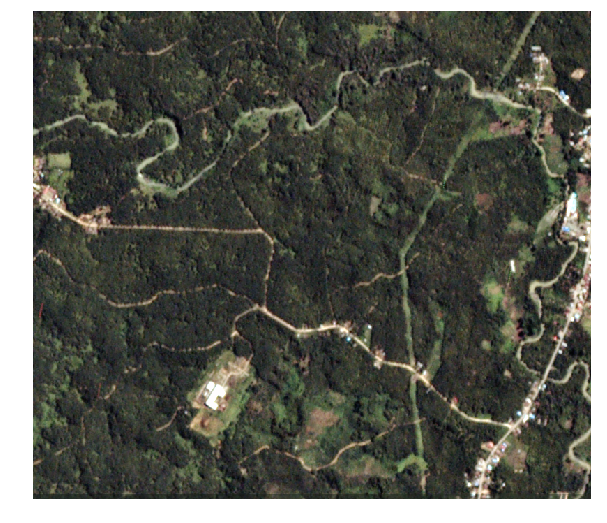

In [6]:
# plot rgb
fig = plt.figure(figsize=figsize)
axH = plt.axes()
plt.imshow(img_rgb)
axH.axis("off");
if img_out_format:
    plt.savefig(os.path.join(img_out_dir, img_out_fn + "." + img_out_format), orientation='portrait')

In [7]:
# convolute image with horizontal bar and vertical bar:
# - list of functions returning small 2D matrices to be used for convolution (defined in source/models/data)
conv_matrix_fun = [conv_matrix_inhibsurround,
                   conv_matrix_horizontalbar,
                   conv_matrix_verticalbar,
                   conv_matrix_diag_llur,
                   conv_matrix_diag_ullr]
# - run convolutions (bands of input array img_rgb will be collapsed into one; output will have as many 'bands' as 
# there are entries in conv_matrix_fun defined above)
img_f = feature_eng_conv(img_rgb, conv_matrix_fun, n=5, collapse_bands=True)

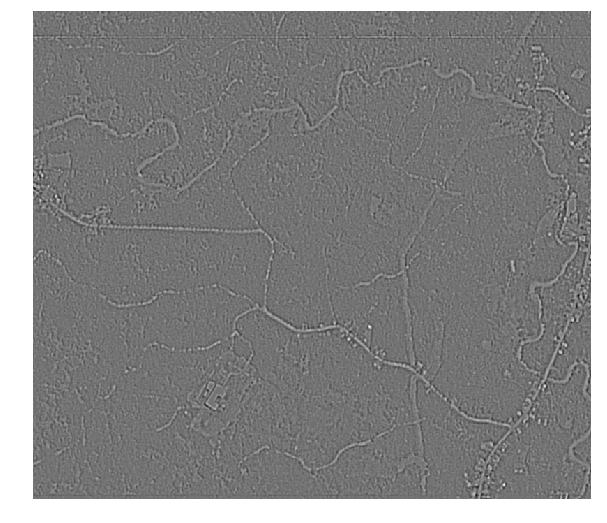

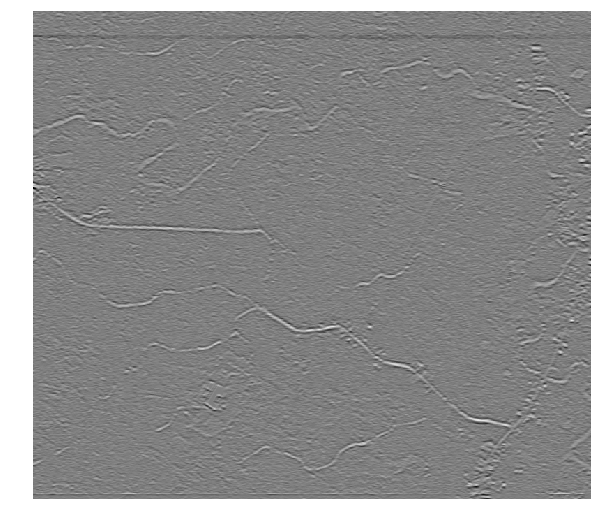

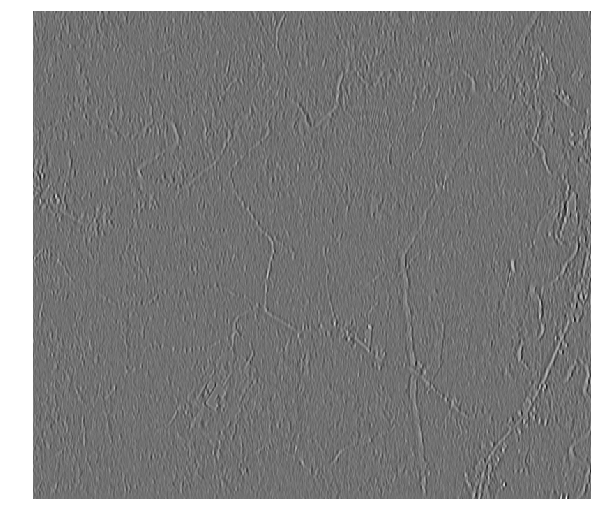

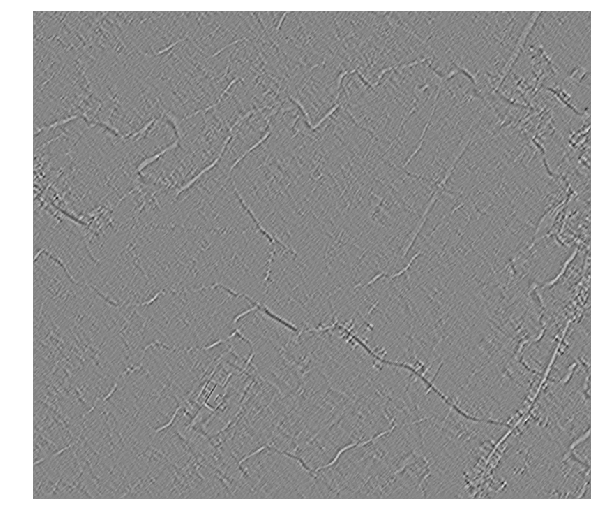

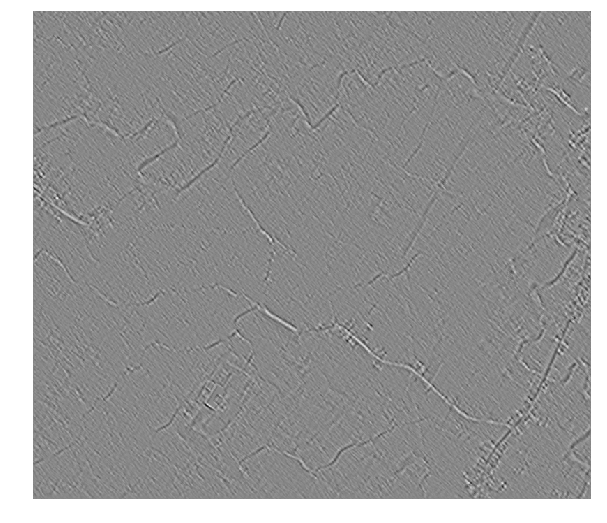

In [8]:
# plot
for ix in range(img_f.shape[2]):
    fig = plt.figure(figsize=figsize)
    axH = plt.axes()
    plt.imshow(img_f[:,:,ix], cmap="gray")
    axH.axis("off");
    if img_out_format:
        plt.savefig(os.path.join(img_out_dir, img_out_fn + "_conv" + str(ix) + "." + img_out_format), orientation='portrait')

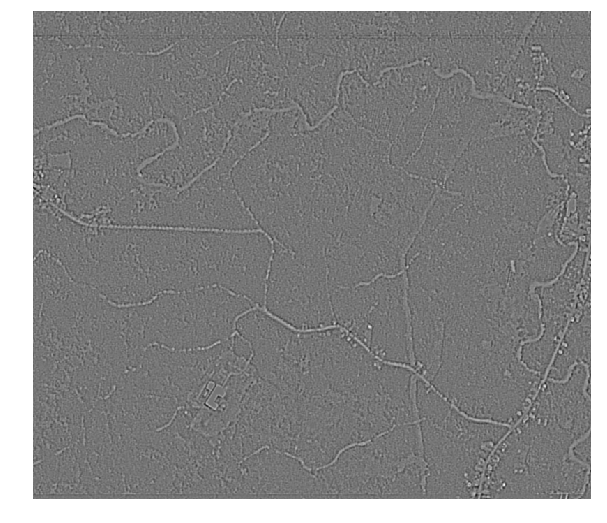

In [9]:
# for the fun of it, plot average, too
fig = plt.figure(figsize=figsize)
axH = plt.axes()
plt.imshow(np.mean(img_f, axis=2), cmap="gray")
axH.axis("off");